# SNR Age Estimation

In [1]:
# %load firstcell.py
# autoreloading for imported modules
%load_ext autoreload
%autoreload 2

# getting future division
from __future__ import division

# numpy
import numpy as np
from numpy import pi, sqrt, log, log10, power, exp

#scipy
from scipy.interpolate import interp1d

# matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import rc
from matplotlib.lines import Line2D

# other
import os
from tqdm import tqdm

# matplotlib style
%matplotlib inline

%config InlineBackend.figure_format = "retina"
rcParams['figure.figsize'] = (13, 8)
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['New Times Roman']
rc('text', usetex=True)

# current directory
current_dir = os.getcwd()

In [2]:
from random import random

import sys
sys.path.insert(0, '../')

import constants as ct
import particle as pt
import astro as ap
import echo as ec
import routines as rt
import data as dt

/home/buenabad/anaconda2/lib/python2.7/site-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "
/home/buenabad/anaconda2/lib/python2.7/site-packages/healpy/fitsfunc.py:403: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  warnings.warn("No INDXSCHM keyword in header file : " "assume {}".format(schm))


NSIDE = 512
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
G4.5+6.8 is suggested to be related to SN explosion at AD:1604
it is about 417 years old.
G7.7-3.7 is suggested to be related to SN explosion at AD:386
it is about 1635 years old.
G11.2-0.3 is suggested to be related to SN explosion at AD:386
it is about 1635 years old.
G69.0+2.7 is suggested to be related to SN explosion at AD:1408
it is about 613 years old.
G111.7-2.1 could be related to  a late 17th century SN.
it is about 321 years old.
G120.1+1.4 is suggested to be related to SN explosion at AD:1572
it is about 449 years old.
G130.7+3.1 is suggested to be related to SN explosion at AD:1181
it is about 840 years old.
G184.6-5.8 is suggested to be related to SN explosion at AD:1054
it is about 967 years old.
G315.4-2.3 is suggested to be related to SN explosion at AD:185
it is about 1836 years old.
G320.4-1.2 is suggested to be related to SN explosion at AD:185
it is about 1836 years old.
G327.

In [3]:
# The contents of data.py
dir(dt)

['ED_fn',
 'Rb_fn',
 'ST_fn',
 'Simbad',
 'SkyCoord',
 'SuperNova',
 'SuperNovaRemnant',
 '__builtins__',
 '__doc__',
 '__file__',
 '__name__',
 '__package__',
 'clean_white_spaces',
 'ct',
 'data_path',
 'datetime',
 'division',
 'exp',
 'gen_SN_with_table2',
 'load_Bietenholz',
 'load_Green_catalogue',
 'load_Green_catalogue_names',
 'load_table2',
 'log',
 'log10',
 'model_age',
 'name',
 'np',
 'os',
 'pi',
 'power',
 're',
 'simbad_to_galactic',
 'snr',
 'snr_name_arr',
 'snrs_age',
 'snrs_age_only',
 'snrs_cut',
 'snrs_dct',
 'sqrt',
 'test2',
 'update_Bietenholz_with_coord',
 'update_Bietenholz_with_table2',
 'zeros']

In [5]:
print(len(dt.snrs_dct))
print(len(dt.snrs_cut))
print(len(dt.snrs_age))
print(len(dt.snrs_age_only))

294
72
7
11


In [6]:
# Also called Cassiopeia A
CasA = 'G111.7-2.1'
dt.snrs_cut[CasA].__dict__

{'age': 321.0,
 'alpha': 0.77,
 'ang_size': 5.0,
 'b': -2.1,
 'distance': 3.3,
 'is_complete': False,
 'is_flux_certain': True,
 'is_spectral_certain': True,
 'is_type_certain': True,
 'l': 111.7,
 'name': 'G111.7-2.1',
 'no_dist': False,
 'no_flux': False,
 'snu_at_1GHz': 2300.0,
 'sr': 1.6614302187698022e-06,
 'type': 'S'}

In [7]:
# Also called W50
W50 = 'G39.7-2.0'
dt.snrs_cut[W50].__dict__

{'alpha': 0.7,
 'ang_size': 84.8528137423857,
 'b': -2.0,
 'distance': 4.9,
 'is_complete': False,
 'is_flux_certain': False,
 'is_spectral_certain': False,
 'is_type_certain': False,
 'l': 39.7,
 'name': 'G39.7-2.0',
 'no_dist': False,
 'no_flux': False,
 'snu_at_1GHz': 85.0,
 'sr': 0.0004784858509023251}

In [8]:
# Also called W28
W28 = 'G6.4-0.1'
dt.snrs_dct[W28].__dict__

{'ang_size': 48.0,
 'b': -0.1,
 'distance': 1.9,
 'is_complete': False,
 'is_flux_certain': True,
 'is_spectral_certain': False,
 'is_type_certain': True,
 'l': 6.4,
 'name': 'G6.4-0.1',
 'no_dist': False,
 'no_flux': False,
 'snu_at_1GHz': 310.0,
 'sr': 0.00015311679381005744,
 'type': 'C'}

In [4]:
# Computing age and radius for those SNR for which we know both:

TR_arr = []

for name, snr in dt.snrs_age_only.items():
    if snr.no_dist:
        continue
    try:
        R = snr.get_radius()
        print name, R, snr.age
        TR_arr.append([snr.age, R])
    except:
        continue

TR_arr = np.array(TR_arr)
TR_arr = np.sort(TR_arr, axis=0)
# print TR_arr
TR_arr = TR_arr[:-1]

G120.1+1.4 2.7343491614577826 449.0
G11.2-0.3 2.55981623625835 1635.0
G315.4-2.3 14.04990047855435 1836.0
G69.0+2.7 35.48836145721803 613.0
G111.7-2.1 2.3998277214922035 321.0
G327.6+14.6 8.072147790473773 1015.0
G4.5+6.8 1.3744467859455345 417.0
G320.4-1.2 26.47082698858066 1836.0


### 4.1 Linear Regression

In [5]:
from sklearn.linear_model import LinearRegression as LR

In [6]:
X = TR_arr[:,1].reshape((-1, 1)) # training sample, of shape (n_samples, n_features)
y = TR_arr[:,0] # target values, of shape (, n_samples)

In [7]:
reg_lin = LR().fit(X, y)
reg_log = LR().fit(log10(X), log10(y))

print reg_lin.score(X, y)
print reg_log.score(log10(X), log10(y))

def lin_reg_pred(R, method='lin'):
    
    R_arr = np.array(R).reshape(-1, 1)
    
    if method == 'lin':
        return reg_lin.predict(R_arr)
    elif method == 'log':
        return 10.**reg_log.predict(log10(R_arr))
    else:
        raise ValueError("method={} cannot be used. Use 'lin' or 'log'".format(method))

0.8931673594675373
0.9665558969771819


### 4.2 Physical model

In [13]:
help(dt.ED_fn)

Help on function ED_fn in module data:

ED_fn(t, t_bench, R_bench, model)
    Blast radius [pc] as a function of time for the Ejecta-Dominated era. Based on Truelove & McKee 1999 (TM99).
    
    Parameters
    ----------
    t : time [years]
    t_bench : benchmark time [years]
    R_bench : benchmark radius [pc]
    model : model of the expansion ('TM99-simple'/'TM99-0' for a simplified version of TM99 or for the case with n=0 ejecta.)



In [14]:
help(dt.ST_fn)

Help on function ST_fn in module data:

ST_fn(t, t_bench, R_bench, model)
    Blast radius [pc] as a function of time for the Sedov-Taylor era. Based on Truelove & McKee 1999 (TM99).
    
    Parameters
    ----------
    t : time [years]
    t_bench : benchmark time [years]
    R_bench : benchmark radius [pc]
    model : model of the expansion ('TM99-simple'/'TM99-0' for a simplified version of TM99 or for the case with n=0 ejecta.)



In [15]:
help(dt.Rb_fn)

Help on function Rb_fn in module data:

Rb_fn(t, t_bench, R_bench, model)
    Blast radius [pc] as a function of time. Based on Truelove & McKee 1999 (TM99).
    
    Parameters
    ----------
    t : time [years]
    t_bench : benchmark time [years]
    R_bench : benchmark radius [pc]
    model : model of the expansion ('TM99-simple'/'TM99-0' for a simplified version of TM99 or for the case with n=0 ejecta.)



In [16]:
help(dt.model_age)

Help on function model_age in module data:

model_age(R, model='estimate', M_ej=1.0, E_sn=1.0, rho0=1.0)
    R : SNR radius today [pc]
    model : 'estimate'/'TM99-simple'/TM99-0'': whether the simple one-phase 'estimate' model is used, or instead the two-phase Truelove-McKee model (ED-ST, or Ejecta-Dominated -- Sedov-Taylor), either in a simplified form, or for n=0 (uniform) ejecta profile.
    M_ej : Mass of the ejecta [M_sun] (default: 1.)
    E_sn : Energy of the SNR [1.e51 ergs] (default: 1.)
    rho0 : Mass density of surrounding medium [m_proton/cm^3] (default: 1.)



/home/buenabad/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


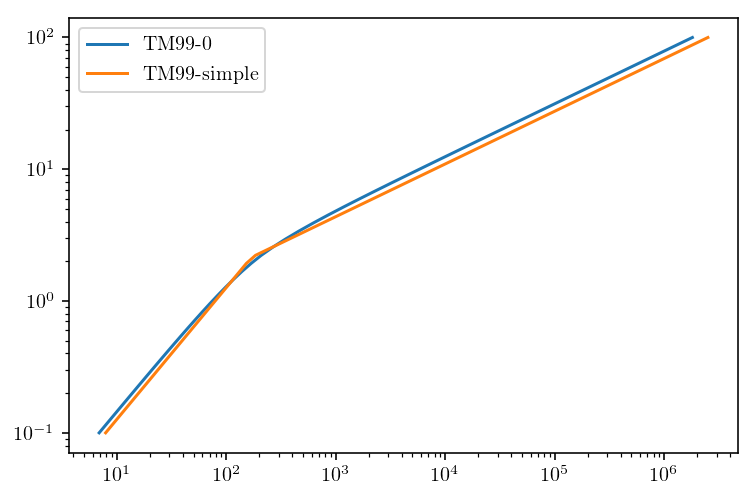

In [17]:
R_arr = np.logspace(-1, 2)

tarr = np.array([dt.model_age(R, model='TM99-0') for R in R_arr])
tarr2 = np.array([dt.model_age(R, model='TM99-simple') for R in R_arr])

plt.loglog(tarr, R_arr, label="TM99-0")
plt.loglog(tarr2, R_arr, label="TM99-simple")
plt.legend();

### 4.3 Results

In [18]:
snr = dt.snrs_cut[CasA]

RCasA = snr.get_radius()
print 'CasA: R={} pc, age={} years'.format(RCasA, snr.age)

# rho0 and M_ej values from TM99 Table 1
print 'lin. reg., linear data:', lin_reg_pred(RCasA, method='lin')
print 'lin. reg., log data:', lin_reg_pred(RCasA, method='log')
print 'estimate', dt.model_age(RCasA, model='estimate', rho0=3.2, M_ej=3.)
print 'TM99-simple', dt.model_age(RCasA, model='TM99-simple', rho0=3.2, M_ej=3.)
print 'TM99-0', dt.model_age(RCasA, model='TM99-0', rho0=3.2, M_ej=3.)

del snr

CasA: R=2.39982772149 pc, age=321.0 years
lin. reg., linear data: [528.80690033]
lin. reg., log data: [467.46896533]
estimate 1001.2986332109173
TM99-simple [398.87284747]
TM99-0 [414.87886573]


In [19]:
M_ej_bench = 1.
rho0_bench = 1.
E_sn_bench = 1.

for name, snr in dt.snrs_age_only.items():
    try:
        snr.get_distance()
    except:
        continue
    
    Rsnr = snr.get_radius()
    print 'SNR {}:\n\tR={} pc, age={} years\n'.format(name, Rsnr, snr.age)
    print '\tlin. reg., linear:', lin_reg_pred(Rsnr, method='lin')
    print '\tlin. reg., log:', lin_reg_pred(Rsnr, method='log')
    print '\testimate', dt.model_age(Rsnr, model='estimate', M_ej=M_ej_bench, rho0=rho0_bench, E_sn=E_sn_bench)
    print '\tTM99-simple', dt.model_age(Rsnr, model='TM99-simple', M_ej=M_ej_bench, rho0=rho0_bench, E_sn=E_sn_bench)
    print '\tTM99-0', dt.model_age(Rsnr, model='TM99-0', M_ej=M_ej_bench, rho0=rho0_bench, E_sn=E_sn_bench)
    print '\n'

SNR G120.1+1.4:
	R=2.73434916146 pc, age=449.0 years

	lin. reg., linear: [549.96372149]
	lin. reg., log: [507.18541181]
	estimate 775.6635736901013
	TM99-simple [308.98987381]
	TM99-0 [298.68194234]


SNR G11.2-0.3:
	R=2.55981623626 pc, age=1635.0 years

	lin. reg., linear: [538.92538001]
	lin. reg., log: [486.70652078]
	estimate 657.7493736374353
	TM99-simple [262.01810018]
	TM99-0 [264.47327769]


SNR G315.4-2.3:
	R=14.0499004786 pc, age=1836.0 years

	lin. reg., linear: [1265.61619375]
	lin. reg., log: [1410.38679236]
	estimate 46421.758689682545
	TM99-simple [18492.36427486]
	TM99-0 [13422.83375456]


SNR G69.0+2.7:
	R=35.4883614572 pc, age=613.0 years

	lin. reg., linear: [2621.49247153]
	lin. reg., log: [2516.48818796]
	estimate 470709.9075733714
	TM99-simple [187509.89459103]
	TM99-0 [135414.03725022]


SNR G111.7-2.1:
	R=2.39982772149 pc, age=321.0 years

	lin. reg., linear: [528.80690033]
	lin. reg., log: [467.46896533]
	estimate 559.7429524093099
	TM99-simple [222.97670033]


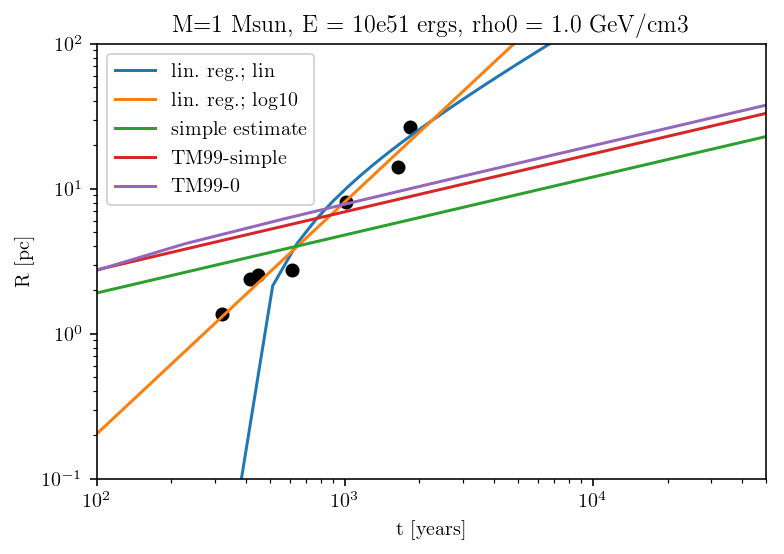

In [19]:
M_ej_bench = 1.
E_sn_bench = 1.
rho0_bench = 1.

R_arr = np.linspace(0.1, 100)

lin_t_arr = lin_reg_pred(R_arr, method='lin')
log_t_arr = lin_reg_pred(R_arr, method='log')

est_t_arr = np.array([dt.model_age(R,
                                model='estimate',
                                M_ej=M_ej_bench,
                                E_sn=E_sn_bench,
                                rho0=rho0_bench)
                      for R in R_arr])
TMs_t_arr = np.array([dt.model_age(R,
                                model='TM99-simple',
                                M_ej=M_ej_bench,
                                E_sn=E_sn_bench,
                                rho0=rho0_bench)
                      for R in R_arr])
TM0_t_arr = np.array([dt.model_age(R,
                                model='TM99-0',
                                M_ej=M_ej_bench,
                                E_sn=E_sn_bench,
                                rho0=rho0_bench)
                      for R in R_arr])


plt.scatter(TR_arr[:,0], TR_arr[:,1], color="k")
plt.plot(lin_t_arr, R_arr, label="lin. reg.; lin")
plt.plot(log_t_arr, R_arr, label="lin. reg.; log10")
plt.plot(est_t_arr, R_arr, label="simple estimate")
plt.plot(TMs_t_arr, R_arr, label="TM99-simple")
plt.plot(TM0_t_arr, R_arr, label="TM99-0")

plt.title("M={} Msun, E = {}e51 ergs, rho0 = {} GeV/cm3".format(int(M_ej_bench), int(E_sn_bench), round(rho0_bench, 1)))


plt.xlim(100, 50000);
plt.xscale("log");
plt.xlabel("t [years]")

# plt.ylim(-.01, 0.1);
plt.ylim(0.1, 100);
plt.yscale("log");
plt.ylabel("R [pc]")

plt.legend();

In [21]:
all_Rs = {}

for name, snr in dt.snrs_dct.items():
# for name, snr in dt.snrs_cut.items():
    if snr.no_dist:
        continue
    try:
        R = snr.get_radius()
    except:
        continue
    
    all_Rs[name] = R

del R

In [22]:
# are Schutz's special SNRs here?
print W28 in all_Rs.keys()
print W50 in all_Rs.keys()

RW28, RW50 = all_Rs[W28], all_Rs[W50]

print W28, RW28, dt.model_age(RW28, model="TM99-0"), dt.model_age(RW28, model="TM99-simple"), lin_reg_pred(RW28, method="lin"), lin_reg_pred(RW28, method="log")

print W50, RW50, dt.model_age(RW50, model="TM99-0"), dt.model_age(RW50, model="TM99-simple"), lin_reg_pred(RW50, method="lin"), lin_reg_pred(RW50, method="log")

True
True
G6.4-0.1 13.264502315156903 [11635.01525015] [16015.36052696] [1215.94365711] [1360.5906602]
G39.7-2.0 60.47257332493333 [513057.76062227] [710731.30428896] [4201.61989878] [3511.0395109]


In [23]:
min_R, max_R = min(all_Rs.values()), max(all_Rs.values())
min_R_name, max_R_name = min(all_Rs, key=all_Rs.__getitem__), max(all_Rs, key=all_Rs.__getitem__)

print min_R_name, all_Rs[min_R_name]
print max_R_name, all_Rs[max_R_name]

G4.5+6.8 1.3744467859455345
G39.7-2.0 60.47257332493333


In [32]:
M_ej_bench = 10.
E_sn_bench = 1.
rho0_bench = 0.2

print dt.model_age(min_R, model="TM99-0", 
                   M_ej=M_ej_bench,
                   E_sn=E_sn_bench,
                   rho0=rho0_bench), dt.model_age(min_R, model="TM99-simple", 
                   M_ej=M_ej_bench,
                   E_sn=E_sn_bench,
                   rho0=rho0_bench), lin_reg_pred(min_R, method="lin"), lin_reg_pred(min_R, method="log")

print dt.model_age(max_R, model="TM99-0", 
                   M_ej=M_ej_bench,
                   E_sn=E_sn_bench,
                   rho0=rho0_bench), dt.model_age(max_R, model="TM99-simple", 
                   M_ej=M_ej_bench,
                   E_sn=E_sn_bench,
                   rho0=rho0_bench), lin_reg_pred(max_R, method="lin"), lin_reg_pred(max_R, method="log")

[303.13318703] [342.2093515] [463.95664417] [329.99019833]
[230294.04125694] [317848.70202544] [4201.61989878] [3511.0395109]
